<a href="https://colab.research.google.com/github/mlimbuu/pytorch-GAT/blob/main/pytorch_SparseGAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up Environment

In [ ]:
# !pip install torch==2.3.0
# !pip install networkx==3.3
# !pip install scipy==1.13.0
# !pip install numpy==1.26.4
# !pip install jupyter==1.0.0

In [27]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


import os
import glob
import time
import random
import argparse
import numpy as np
import scipy.sparse as sp

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Data Loading & Data Processing

In [28]:
import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall("data")

In [29]:
def encode_onehot(labels):
    # The classes must be sorted before encoding to enable static class encoding.
    # In other words, make sure the first class always maps to index 0.
    classes = sorted(list(set(labels)))
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot

def normalize_adj(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt)
    return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)

def normalize_features(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def load_data(path="./data/data/cora/", dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset), dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset), dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    # normalize features and adjacency matrix
    features = normalize_features(features)
    adj = normalize_adj(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    adj = torch.FloatTensor(np.array(adj.todense()))
    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test


In [30]:
# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data()

Loading cora dataset...


# Data Visualization

# Sparse GAT Layer

In [31]:
class SpecialSpmmFunction(torch.autograd.Function):
    """Special function for only sparse region backpropataion layer."""
    @staticmethod
    def forward(ctx, indices, values, shape, b):
        assert indices.requires_grad == False
        a = torch.sparse_coo_tensor(indices, values, shape)
        ctx.save_for_backward(a, b)
        ctx.N = shape[0]
        return torch.matmul(a, b)

    @staticmethod
    def backward(ctx, grad_output):
        a, b = ctx.saved_tensors
        grad_values = grad_b = None
        if ctx.needs_input_grad[1]:
            grad_a_dense = grad_output.matmul(b.t())
            edge_idx = a._indices()[0, :] * ctx.N + a._indices()[1, :]
            grad_values = grad_a_dense.view(-1)[edge_idx]
        if ctx.needs_input_grad[3]:
            grad_b = a.t().matmul(grad_output)
        return None, grad_values, None, grad_b

class SpecialSpmm(nn.Module):
    def forward(self, indices, values, shape, b):
        return SpecialSpmmFunction.apply(indices, values, shape, b)

In [32]:
class Sparse_GraphAttentionLayer(nn.Module):
    """
    Sparse version GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(Sparse_GraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_normal_(self.W.data, gain=1.414)

        self.a = nn.Parameter(torch.zeros(size=(1, 2*out_features)))
        nn.init.xavier_normal_(self.a.data, gain=1.414)

        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(self.alpha)
        self.special_spmm = SpecialSpmm()

    def forward(self, input, adj):
        dv = 'cuda' if input.is_cuda else 'cpu'

        N = input.size()[0]
        edge = adj.nonzero().t()

        h = torch.mm(input, self.W)
        # h: N x out
        assert not torch.isnan(h).any()

        # Self-attention on the nodes - Shared attention mechanism
        edge_h = torch.cat((h[edge[0, :], :], h[edge[1, :], :]), dim=1).t()
        # edge: 2*D x E

        edge_e = torch.exp(-self.leakyrelu(self.a.mm(edge_h).squeeze()))
        assert not torch.isnan(edge_e).any()
        # edge_e: E

        e_rowsum = self.special_spmm(edge, edge_e, torch.Size([N, N]), torch.ones(size=(N,1), device=dv))
        # e_rowsum: N x 1

        edge_e = self.dropout(edge_e)
        # edge_e: E

        h_prime = self.special_spmm(edge, edge_e, torch.Size([N, N]), h)
        assert not torch.isnan(h_prime).any()
        # h_prime: N x out

        h_prime = h_prime.div(e_rowsum)
        # h_prime: N x out
        assert not torch.isnan(h_prime).any()

        if self.concat:
            # if this layer is not last layer,
            return F.elu(h_prime)
        else:
            # if this layer is last layer,
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


# Sparse GAT Model

In [33]:
class Sparse_GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        """Sparse version of GAT."""
        super(Sparse_GAT, self).__init__()
        self.dropout = dropout

        self.attentions = [Sparse_GraphAttentionLayer(nfeat,
                                                 nhid,
                                                 dropout=dropout,
                                                 alpha=alpha,
                                                 concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = Sparse_GraphAttentionLayer(nhid * nheads,
                                             nclass,
                                             dropout=dropout,
                                             alpha=alpha,
                                             concat=False)

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_att(x, adj))
        return F.log_softmax(x, dim=1)



# Model Training

In [34]:
# Training & Test

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.data.item()),
          'acc_train: {:.4f}'.format(acc_train.data.item()),
          'loss_val: {:.4f}'.format(loss_val.data.item()),
          'acc_val: {:.4f}'.format(acc_val.data.item()),
          'time: {:.4f}s'.format(time.time() - t))

    return loss_val, acc_val, output

def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.data.item()),
          "accuracy= {:.4f}".format(acc_test.data.item()))


In [40]:
# Parameters
seed = 72
epochs = 1000
lr = 0.005
weight_decay = 5e-4
hidden = 8
nb_heads = 8
dropout = 0.6
alpha = 0.2
patience = 100

In [41]:
# Initialize model
model = Sparse_GAT(nfeat=features.shape[1], nhid=hidden, nclass=int(labels.max()) + 1, dropout=dropout, nheads=nb_heads, alpha=alpha)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


In [ ]:
val_acc_list = []
val_loss_list = []

# Training model
for epoch in range(epochs):
    print(f"Training: {epoch}")
    val_loss, val_acc, out_features = train(epoch)
    print(f"loss_val:{val_loss}, val_acc:{val_acc}, out_features:{out_features}")
    # val_acc_list.append(val_acc.item())
    # val_loss_list.append(loss_val.item())
    val_loss_list.append(val_loss.item())
    val_acc_list.append(val_acc.item())

# Testing model
test()

Streaming output truncated to the last 5000 lines.
        [-1.9459e+00, -1.9459e+00, -1.9459e+00,  ..., -1.9459e+00,
         -1.9459e+00, -1.9459e+00],
        [-7.5749e+00, -8.2265e+00, -5.0076e-03,  ..., -8.2599e+00,
         -7.8295e+00, -8.2482e+00]], grad_fn=<LogSoftmaxBackward0>)
Training: 429
Epoch: 0430 loss_train: 0.7497 acc_train: 0.7643 loss_val: 1.0279 acc_val: 0.6167 time: 1.7340s
loss_val:1.0278730392456055, val_acc:0.6166666666666667, out_features:tensor([[-5.6819e+00, -5.7515e+00, -5.4570e-02,  ..., -5.5676e+00,
         -5.5434e+00, -5.1920e+00],
        [-2.3693e+00, -3.6388e+00, -3.0708e+00,  ..., -2.5069e+00,
         -1.1623e+00, -8.8110e-01],
        [-1.7357e+00, -1.7718e+00, -2.4430e+00,  ..., -1.4355e+00,
         -2.1238e+00, -2.2585e+00],
        ...,
        [-3.7013e+00, -1.2011e-01, -4.2276e+00,  ..., -4.0672e+00,
         -4.0693e+00, -3.6153e+00],
        [-1.4048e-01, -3.2598e+00, -4.8157e+00,  ..., -3.4096e+00,
         -3.3874e+00, -4.6031e+00],
   

# Result Visualization

## 1. Visualize earned feature representation

In [45]:
# visualize learned feature representation
def visualize_learnedFeature_tSNE(labels, out_features, dataset):
    color_map = {0: "red", 1: "blue", 2: "green",
                           3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

    if dataset =='citeseer':
        num_classes = 6
    elif dataset == 'cora':
        num_classes = 7
    elif dataset =='pubmed':
        num_classes = 3
    node_labels = labels.cpu().numpy()
    out_features = out_features.cpu().detach().numpy()
    t_sne_X = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(out_features)

    plt.figure()
    for class_id in range(num_classes):
        plt.scatter(t_sne_X[node_labels == class_id, 0],
                    t_sne_X[node_labels == class_id, 1], s=20,
                    color=color_map[class_id],
                    edgecolors='black', linewidths=0.15)

    plt.axis("off")
    plt.title("t-SNE projection of the learned features for "+dataset)
    plt.show()


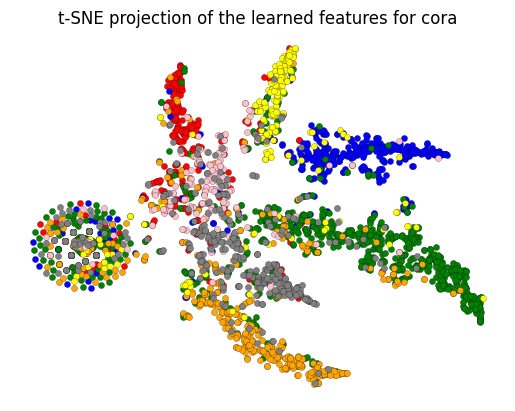

In [46]:
dataset = 'cora'
visualize_learnedFeature_tSNE(labels, out_features, dataset)

## 2. Visulaize validation loss and accuracy

In [47]:
# visulaize validation loss and accuracy
def visualize_validation_performance(val_acc, val_loss):
    f, ax = plt.subplots(1, 2, figsize=(13, 5.5))
    ax[0].plot(val_loss, linewidth=2, color="red")
    ax[0].set_title("Validation loss")
    ax[0].set_ylabel("Cross Entropy Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].grid()
    ax[1].plot(val_acc, linewidth=2, color="red")
    ax[1].set_title("Validation accuracy")
    ax[1].set_ylabel("Acc")
    ax[1].set_xlabel("Epoch")
    ax[1].grid()

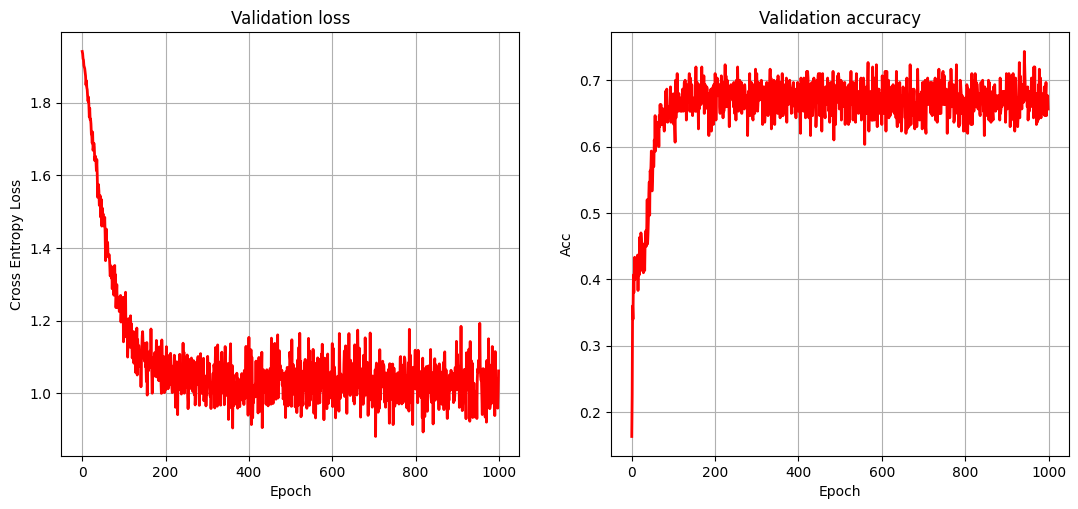

In [48]:
visualize_validation_performance(val_acc_list, val_loss_list)